In [18]:
# import relevant libraries
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

In [2]:
# load preprocessed data
X_train = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/X_train_scaled.csv')
X_test = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/X_test_scaled.csv')
y_train = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/y_train.csv')
y_test = pd.read_csv(r'/Users/adityamxr/Desktop/spotify-time-series/data-analysis/y_test.csv')

In [3]:
# verify import

X_train.head()

,acousticness,danceability,energy,explicit,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,labelenc_genre,duration_s
0,-1.306496,-1.876611,1.091134,0,-0.441361,0.031520,1.435897,1,-0.285366,-0.456439,0.358882,216,-0.765607
1,0.994996,-0.804675,1.072424,0,-0.521536,2.231258,1.467179,0,0.261131,-1.118284,1.308006,95,-0.458954
2,-0.244792,0.803230,-0.065093,0,-0.523093,1.954170,-0.225053,1,-0.241940,-0.128433,0.541846,403,-0.680081
3,-0.887251,0.974284,0.619663,0,-0.523104,-0.596169,0.965960,1,-0.445708,-0.258020,1.132666,403,-0.315422
4,-1.200251,0.153226,0.522375,0,-0.523153,-0.735844,0.152982,1,-0.349503,0.342224,1.388053,403,0.095724


In [4]:
# verify import

X_test.head()

,acousticness,danceability,energy,explicit,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,labelenc_genre,duration_s
0,-1.035920,1.487445,-0.802234,0,-0.523051,-0.623878,-1.197975,1,-0.379567,-0.259388,-0.007046,519,-0.410379
1,1.284368,0.626475,-1.681191,0,-0.522972,-0.648759,-1.945562,1,-0.378899,-1.325988,-0.780830,488,0.078591
2,1.300297,0.780423,-0.457985,0,-0.523153,3.594078,0.689371,1,0.107471,-0.662287,0.515163,500,-1.108589
3,1.273749,-1.397661,-1.266221,0,-0.519629,-0.409559,-0.266939,0,-0.360192,-1.758596,-1.642285,344,-0.154872
4,0.721552,0.124717,-0.405600,0,1.772205,-0.806529,-0.069350,1,-0.396269,-1.178940,-0.544502,224,3.124084


In [5]:
# verify import

y_train.head()

,popularity_binned
0,High
1,Low
2,Low
3,High
4,Low


In [6]:
# verify import

y_test.head()

,popularity_binned
0,High
1,Low
2,Low
3,Low
4,Low


In [7]:
# ensure target variables are in the correct format
y_train = y_train.values.ravel()  # Convert to 1D array if needed
y_test = y_test.values.ravel()

# verify shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (135927, 13)
X_test shape: (33982, 13)
y_train shape: (135927,)
y_test shape: (33982,)


In [8]:
# print original class distribution
print("Original class distribution:", Counter(y_train))

# initialize SMOTE
smote = SMOTE(random_state=42)

# apply SMOTE to both X_train and y_train
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print new class distribution
print("Class distribution after SMOTE:", Counter(y_train_smote))

# reprint shapes
print("Shape of X_train before SMOTE:", X_train.shape)
print("Shape of X_train after SMOTE:", X_train_smote.shape)

Original class distribution: Counter({'Low': 72519, 'High': 63408})
Class distribution after SMOTE: Counter({'High': 72519, 'Low': 72519})
Shape of X_train before SMOTE: (135927, 13)
Shape of X_train after SMOTE: (145038, 13)


In [9]:
# initialize the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# perform initial cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_smote, y_train_smote, cv=5, scoring='accuracy')

In [10]:
# print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.79398787 0.79805571 0.79591837 0.7916365  0.81994001]
Mean CV score: 0.7999076915093493


In [11]:
# check for data imbalance

# original training set distribution
y_train_original_distribution = pd.Series(y_train).value_counts(normalize=True)
print("Original training set distribution:")
print(y_train_original_distribution)

# SMOTE-resampled training set distribution
y_train_smote_distribution = pd.Series(y_train_smote).value_counts(normalize=True)
print("\nSMOTE-resampled training set distribution:")
print(y_train_smote_distribution)

# test set distribution (unchanged by SMOTE)
y_test_distribution = pd.Series(y_test).value_counts(normalize=True)
print("\nTest set distribution:")
print(y_test_distribution)

Original training set distribution:
Low     0.533514
High    0.466486
Name: proportion, dtype: float64

SMOTE-resampled training set distribution:
High    0.5
Low     0.5
Name: proportion, dtype: float64

Test set distribution:
Low     0.532517
High    0.467483
Name: proportion, dtype: float64


Train Accuracy (SMOTE Resampled): 91.92%
Test Accuracy: 79.24%

Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.79      0.78     15886
         Low       0.81      0.80      0.80     18096

    accuracy                           0.79     33982
   macro avg       0.79      0.79      0.79     33982
weighted avg       0.79      0.79      0.79     33982


Confusion Matrix:
[[12507  3379]
 [ 3676 14420]]


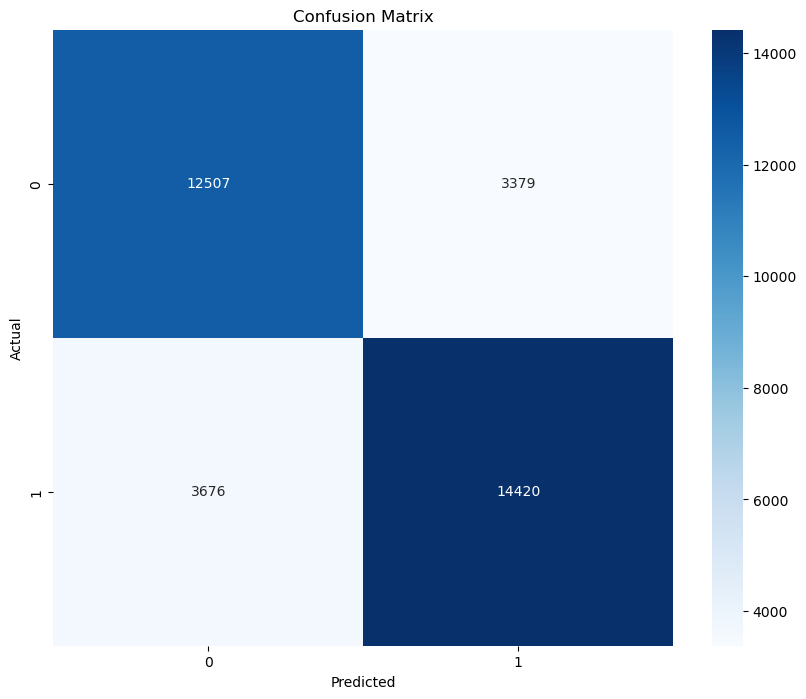

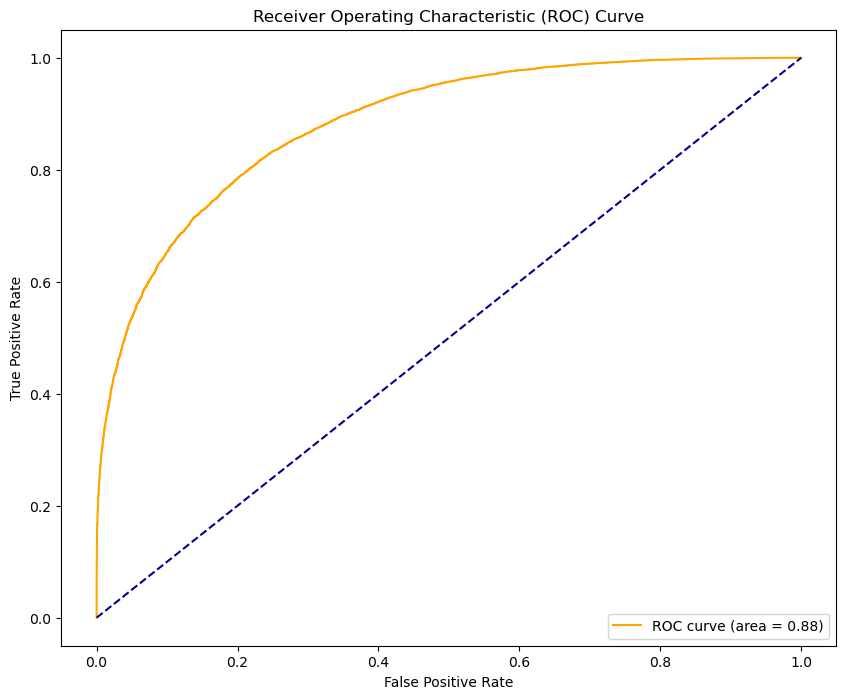

In [12]:
# manually set the RandomForestClassifier with regularization parameters
rf_clf = RandomForestClassifier(
    n_estimators=100,  
    criterion='gini', 
    max_depth=None,  
    min_samples_split=5,  
    min_samples_leaf=6,
)

# fit the model to the SMOTE-resampled training data
rf_clf.fit(X_train_smote, y_train_smote)

# predict on the test set
y_pred = rf_clf.predict(X_test)

train_accuracy = rf_clf.score(X_train_smote, y_train_smote)
print(f"Train Accuracy (SMOTE Resampled): {train_accuracy:.2%}")

test_accuracy = rf_clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2%}")

# print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC-AUC calculation
y_score = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=rf_clf.classes_[1])
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Model accuracies are decent, but let's try XGBoost for comparison

In [13]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/99/a1/5219921a9bcb5388623f81908ff43d606aec2e512e0c02f6eb49f3b3caa8/xgboost-2.1.1-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.5 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [13]:
# set up parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [14]:
# encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_smote_encoded = label_encoder.fit_transform(y_train_smote)
y_test_encoded = label_encoder.transform(y_test)


In [20]:
# initialize XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Your grid search and model fitting code below
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote_encoded)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Test Accuracy: 80.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     15886
           1       0.82      0.80      0.81     18096

    accuracy                           0.80     33982
   macro avg       0.80      0.80      0.80     33982
weighted avg       0.80      0.80      0.80     33982


Confusion Matrix:
[[12714  3172]
 [ 3529 14567]]


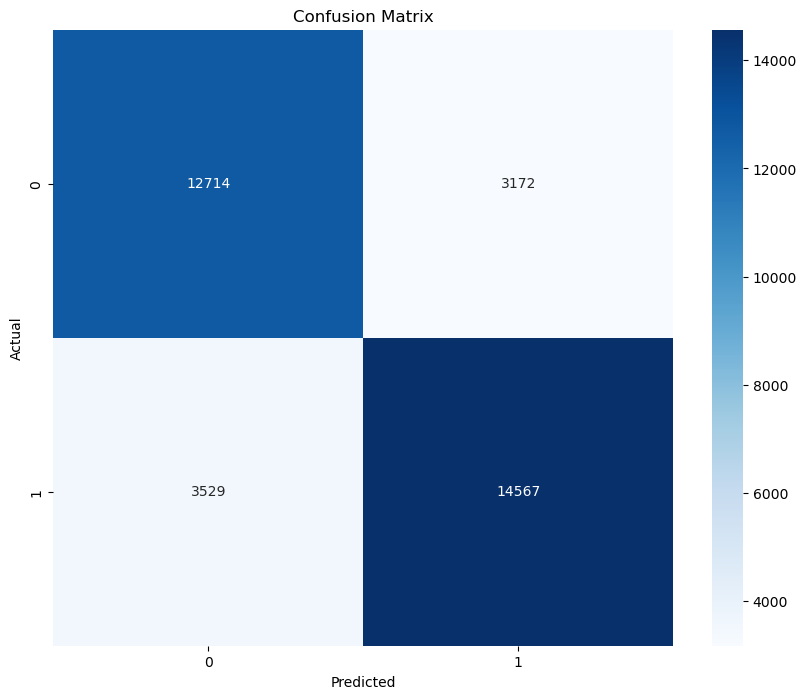

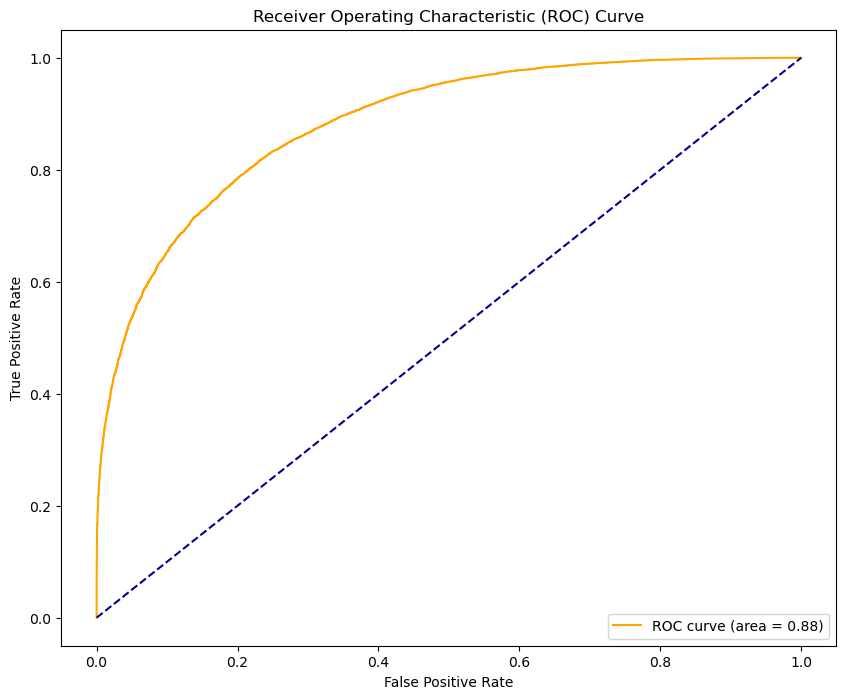

In [21]:
best_xgb_model = grid_search.best_estimator_

# print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# predict on the test set using the best model
y_pred = best_xgb_model.predict(X_test)

# evaluate the model
test_accuracy = best_xgb_model.score(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.2%}")

# print classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Implementation of XGBoost with GridSearch resulted in an increase of 0.97% in model accuracies - model is sufficiently good now

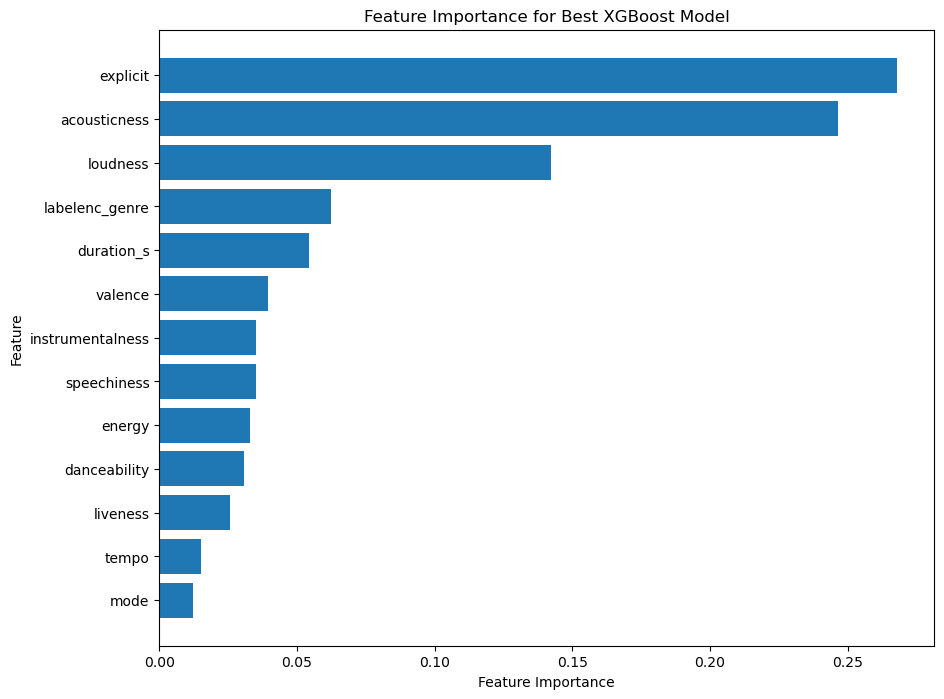

In [22]:
# get feature importances from the model
feature_importances = best_xgb_model.feature_importances_

# sort the features by importance
indices = np.argsort(feature_importances)

# plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(X_train_smote.shape[1]), feature_importances[indices], align='center')
plt.yticks(range(X_train_smote.shape[1]), X_train_smote.columns[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Best XGBoost Model')
plt.show()

### Top 6 Features:
- Explicit
- Acousticness
- Loudness
- Labelenc_genre
- Duration_s
- Valence